In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

%matplotlib inline


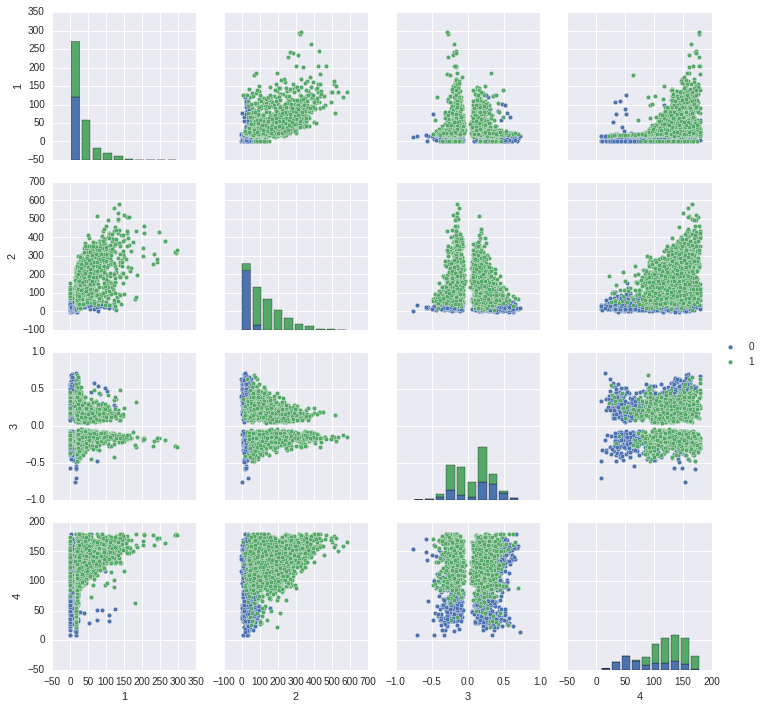

In [68]:
# Import the data
df_exam = pd.read_csv('exam.dat', header=None, sep='[1-4]:', engine='python')

# Summarize
sns.set()
sns.pairplot(df_exam, hue=0, vars=np.arange(1, 5))

print("n = {0}, d = {1}".format(*df_exam.shape))
print("count(g = 0) = {0}, count(g = 1) = {1}".format(sum(df_exam[0] < 0.5), sum(df_exam[0] > 0.5)))


In [89]:
X = df_exam.values[:, 1 :]

mu = np.mean(X, axis = 0)
sigma = np.std(X, axis = 0)
X = (X - mu) / sigma

g = df_exam.values[:, 0]
X_train, X_test, g_train, g_test = train_test_split (X, g, test_size = 0.25)

classifiers = dict()
params_grid = dict()

cv = StratifiedShuffleSplit(g_train, n_iter=5, test_size=1/4, random_state=8) # Generate the cross validation labels

In [91]:
k_range = np.arange (1, 15) # Range of parameter n_neighbors

classifiers["knnc_linear"] = KNeighborsClassifier()
params_grid["knnc_linear"] = dict(n_neighbors = k_range)

grid = GridSearchCV(classifiers["knnc_linear"], param_grid=params_grid["knnc_linear"], cv=cv , verbose=0, n_jobs=4)
grid.fit(X_train, g_train)
grid.score(X_test, g_test)

0.96895213454075035

In [92]:
grid.best_params_

{'n_neighbors': 9}